In [1]:
import numpy as np
from unityagents import UnityEnvironment
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# 2. Examine the State and Action Spaces
In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states[0])
print('So this environment has total 48 state and The state for the both agents looks like: \n {}'.format(env_info.vector_observations))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
So this environment has total 48 state and The state for the both agents looks like: 
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


# 3. Importing Agent and setting hyperparameters

In [5]:
# state_size (int): dimension of each state
# action_size (int): dimension of each action
# random_seed (int): random seed
# BATCH_SIZE (int): mini batch size
# BUFFER_SIZE (int): experience storing lenght, keep it as high as possible
# discount_factor (float): discount factor for calculating Q_target
# tau (float): interpolation parameter for updating target network
# noise_coefficient_start (float): value to be multiplied to OUNoise sample
# noise_coefficient_decay (float): exponential decay factor for value to be multiplied to OUNoise sample
# LR_ACTOR (float): learning rate for actor network
# LR_CRITIC (float): learning rate for critic network
# WEIGHT_DECAY (float): Weight decay for critic network optimizer

# state_size = 24
# action_size = 2
# random_seed = 0
# BATCH_SIZE = 128        
# BUFFER_SIZE = int(1e6)  
# discount_factor = 0.99     
# tau = 8e-2       
# noise_coefficient_start = 20
# noise_coefficient_decay = 250
# LR_ACTOR = 1e-3      
# LR_CRITIC = 1e-3        
# WEIGHT_DECAY = 1e-6      
# ADD_NOISE = True

In [6]:
from agent import Agent

In [7]:
state_size = 24
action_size = 2
random_seed = 0
BATCH_SIZE = 128        
BUFFER_SIZE = int(1e6)  
discount_factor = 0.99     
tau = 8e-2       
noise_coefficient_start = 20
noise_coefficient_decay = 250
LR_ACTOR = 1e-3      
LR_CRITIC = 1e-3        
WEIGHT_DECAY = 1e-6      
ADD_NOISE = True
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
agent_0 = Agent(state_size, action_size, BATCH_SIZE, BUFFER_SIZE, discount_factor, tau, noise_coefficient_start, noise_coefficient_decay, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY)
agent_1 = Agent(state_size, action_size, BATCH_SIZE, BUFFER_SIZE, discount_factor, tau, noise_coefficient_start, noise_coefficient_decay, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY)

cuda:0
cuda:0


# Training

In [8]:
n_episodes = 1000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []
import os
if not os.path.isdir('model'):
    os.mkdir('model')
    
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()                                        # reset Ornstein-Uhlenbeck noise
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, ADD_NOISE)           # agent 1 chooses an action
        action_1 = agent_1.act(states, ADD_NOISE)           # agent 2 chooses an action
        actions = np.concatenate((action_0, action_1), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
        next_states = env_info.vector_observations         # get next states
        next_states = np.reshape(next_states, (1, 48))     # combine each agent's state into one state space
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished

        agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
        agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 10 == 0:
        print('Episode {}\tAverage Reward: {:.3f}'.format(
            i_episode, np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'model/checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'model/checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'model/checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'model/checkpoint_critic_1.pth')
        break

Episode 10	Average Reward: 0.000
Episode 20	Average Reward: 0.005
Episode 30	Average Reward: 0.003
Episode 40	Average Reward: 0.008
Episode 50	Average Reward: 0.008
Episode 60	Average Reward: 0.008
Episode 70	Average Reward: 0.007
Episode 80	Average Reward: 0.007
Episode 90	Average Reward: 0.007
Episode 100	Average Reward: 0.008
Episode 110	Average Reward: 0.008
Episode 120	Average Reward: 0.008
Episode 130	Average Reward: 0.009
Episode 140	Average Reward: 0.009
Episode 150	Average Reward: 0.009
Episode 160	Average Reward: 0.009
Episode 170	Average Reward: 0.011
Episode 180	Average Reward: 0.011
Episode 190	Average Reward: 0.014
Episode 200	Average Reward: 0.012
Episode 210	Average Reward: 0.015
Episode 220	Average Reward: 0.016
Episode 230	Average Reward: 0.017
Episode 240	Average Reward: 0.018
Episode 250	Average Reward: 0.019
Episode 260	Average Reward: 0.022
Episode 270	Average Reward: 0.026
Episode 280	Average Reward: 0.033
Episode 290	Average Reward: 0.037
Episode 300	Average Rew

# Visualizing

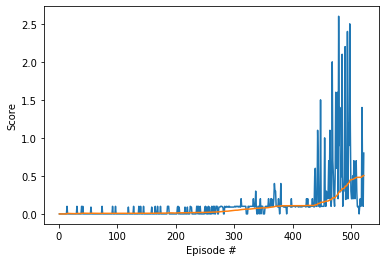

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('score.png')
plt.show()


# Testing 

In [ ]:
env = UnityEnvironment(file_name='./Tennis_Linux/Tennis.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [10]:
#Load the saved training parameters
agent_0.actor_local.load_state_dict(torch.load('model/checkpoint_actor_0.pth', map_location='cpu'))
agent_0.critic_local.load_state_dict(torch.load('model/checkpoint_critic_0.pth', map_location='cpu'))
agent_1.actor_local.load_state_dict(torch.load('model/checkpoint_actor_1.pth', map_location='cpu'))
agent_1.critic_local.load_state_dict(torch.load('model/checkpoint_critic_1.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1,48))

for i in range(200):
    action_0 = agent_0.act(states, add_noise=False)         
    action_1 = agent_1.act(states, add_noise=False)        
    actions = np.concatenate((action_0, action_1), axis=0) 
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break